# Data

## Dataset

In [6]:
import os
import json
import torch
import random
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import savgol, minmax_scaler

label_names = ['AA_SN_X', 'AA_SN_Y', 'AA_SN_Z', 'GH_AA_X', 'GH_AA_Y', 'GH_AA_Z']

class Sensor2AngleDataset(Dataset):
    def __init__(self, dataDir, windowLength):
        self.dataDir = dataDir
        self.windowLength = windowLength
        self.data = self.load_data(dataDir, windowLength)   
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sensorSample, angleSample = self.data[index]
        return sensorSample, angleSample
    
    def load_data(self, dataDir, windowLength, doStandardize=True, doFilter=True):
        sensorPath = Path(dataDir) / "sensor.npy"
        anglePath = Path(dataDir) / "angle.npy"
        with open(sensorPath, 'rb') as f:
            sensorAll = np.load(f)
        with open(anglePath, 'rb') as f:
            angleAll = np.load(f)
        assert sensorAll.shape[0] == angleAll.shape[0]
        if doStandardize:
            sensorAll = self.standardize_sensor(sensorAll)
        if doFilter:
            sensorAll, angleAll = self.filter_sensor_and_angle(sensorAll, angleAll)
        sensorWindowsAll, angleWindowsAll = self.sliding_window(sensorAll, angleAll, windowLength)
        datasetList = []
        for sensorSample, angleSample in zip(sensorWindowsAll, angleWindowsAll):
            datasetList.append([sensorSample, angleSample]) 
        return datasetList
    
    def standardize_sensor(self, sensorAll):
        # TODO
        # sensor-wize standarize
        print(sensorAll.shape)
        sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
        # time-wise standardize
#         scalerStd = StandardScaler()
#         sensorStd = scalerStd.fit_transform(sensorAll)
        return sensorAllStd

    def filter_sensor_and_angle(self, sensorAll, angleAll, do_plot=False):
        for i in range(sensorAll.shape[1]):
            title = f'sensor_{i}'
            sensorAll[:,i] = savgol(sensorAll[:,i], 51, 2, title=title, do_plot=do_plot)
        angleFlt = []
        for i in range(angleAll.shape[1]):
            title = label_names[i]
            angleAll[:,i] = savgol(angleAll[:,i], 51, 2, title=title, do_plot=do_plot)
        return sensorAll, angleAll
    
    def sliding_window(self, sensorAll, angleAll, windowLength):
        senserAllWindows = []
        angleAllWindows = []
        assert(sensorAll.shape[0] == angleAll.shape[0])
        numSample = sensorAll.shape[0]
        for i in range(numSample-windowLength+1):
            _x = sensorAll[i:(i+windowLength)]
            _y = angleAll[i+windowLength-1]
            senserAllWindows.append(_x)
            angleAllWindows.append(_y) 
        return senserAllWindows, angleAllWindows

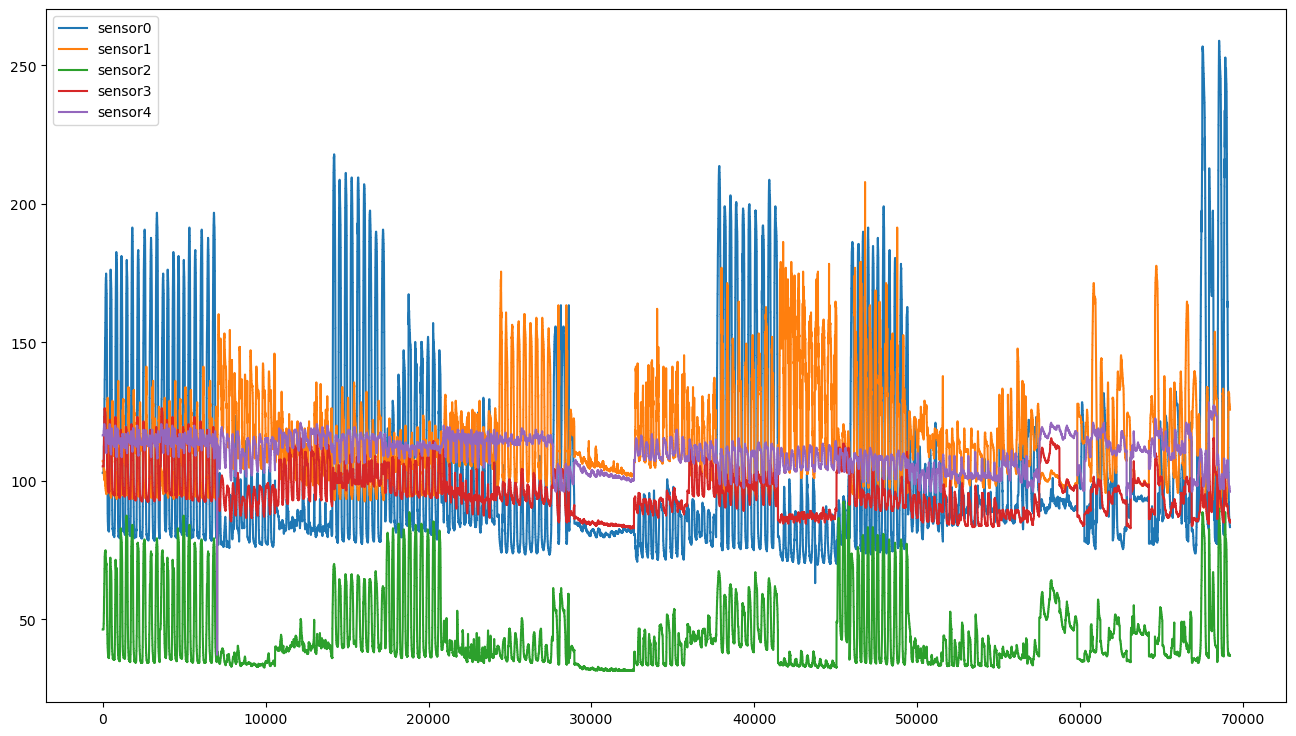

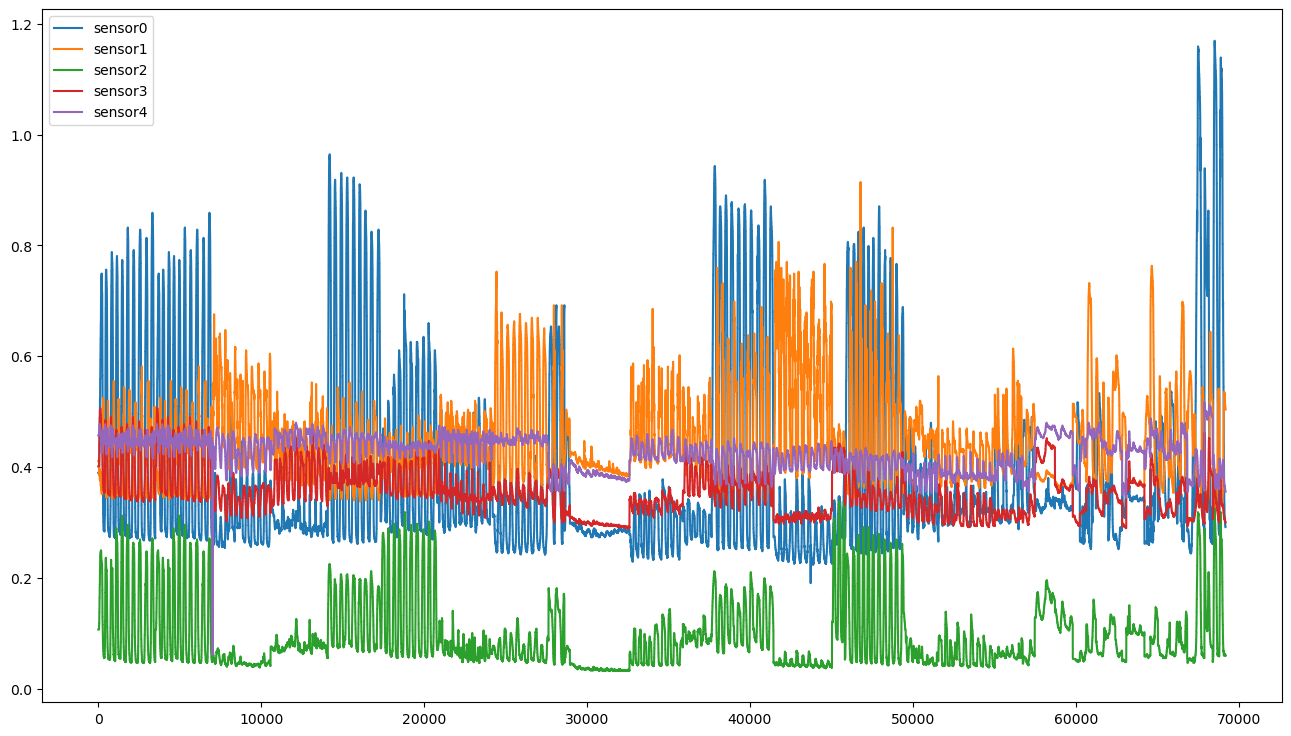

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def compare_standarize_methods(dataDir='./data'):
    sensorPath = Path(dataDir) / "sensor.npy"
    with open(sensorPath, 'rb') as f:
        sensorAll = np.load(f)
    figure(figsize=(16, 9), dpi=100)
    for i in range(5):
        plt.plot(sensorAll[:,i], label=f'sensor{i}')
    plt.legend()
    plt.show()
    
    
    sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
    figure(figsize=(16, 9), dpi=100)
    for i in range(5):
        plt.plot(sensorAllStd[:,i], label=f'sensor{i}')
    plt.legend()
    plt.show()
    
compare_standarize_methods()

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [13]:
import torch
from torch.utils.data import DataLoader, random_split

def collate_batch(batch):
    # Process features within a batch.
    """Collate a batch of data."""
    sensor, angle = zip(*batch)
    return torch.FloatTensor(sensor), torch.FloatTensor(angle)


def get_dataloader(data_dir, windowLength, batch_size, n_workers):
    """Generate dataloader"""
    dataset = Sensor2AngleDataset(data_dir, windowLength)
    # Split dataset into training dataset and validation dataset
    trainlen = int(0.9 * len(dataset))
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)
    
    train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
    )
    valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    pin_memory=False,
    collate_fn=collate_batch,
    )
    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = get_dataloader('./data', 30, 32, 0)
for index, data in enumerate(train_loader):
    print(data[0].size())
    break

# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(5, d_model)
        # TODO:
        #   Change Transformer to Conformer.
        #   https://arxiv.org/abs/2005.08100
        self.encoder_layer = nn.TransformerEncoderLayer(
          d_model=d_model, dim_feedforward=256, nhead=2
        )
        self.pred_layer = nn.Sequential(
          nn.Linear(d_model, d_model),
          nn.ReLU(),
          nn.Linear(d_model, 6),
        )

    def forward(self, mels):
        """
        args:
          mels: (batch size, length, 40)
        return:
          out: (batch size, n_spks)
        """
        # out: (batch size, length, d_model)
        out = self.prenet(mels)
        # out: (length, batch size, d_model)
        out = out.permute(1, 0, 2)
        # The encoder layer expect features in the shape of (length, batch size, d_model).
        out = self.encoder_layer(out)
        # out: (batch size, length, d_model)
        out = out.transpose(0, 1)
        # mean pooling
        stats = out.mean(dim=1)
        # out: (batch, n_output)
        out = self.pred_layer(stats)
        return out
    
    
from torchinfo import summary
print(summary(Attention(d_model=80, dropout=0.1), input_size=(32, 30, 5)))

Layer (type:depth-idx)                   Output Shape              Param #
Attention                                --                        --
├─Linear: 1-1                            [32, 30, 80]              480
├─TransformerEncoderLayer: 1-2           [30, 32, 80]              --
│    └─MultiheadAttention: 2-1           [30, 32, 80]              --
│    └─Dropout: 2-2                      [30, 32, 80]              --
│    └─LayerNorm: 2-3                    [30, 32, 80]              160
│    └─Linear: 2-4                       [30, 32, 256]             20,736
│    └─Dropout: 2-5                      [30, 32, 256]             --
│    └─Linear: 2-6                       [30, 32, 80]              20,560
│    └─Dropout: 2-7                      [30, 32, 80]              --
│    └─LayerNorm: 2-8                    [30, 32, 80]              160
├─Sequential: 1-3                        [32, 6]                   --
│    └─Linear: 2-9                       [32, 80]                  6,480
│

# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [ ]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule twhe learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

    Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
          max(1, num_training_steps - num_warmup_steps)
        )
        return max(
          0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

# Model Function
- Model forward function.

In [ ]:
import torch


def model_fn(batch, model, criterion, device):
    """Forward a batch through the model."""

    mels, labels = batch
    mels = mels.to(device)
    labels = labels.to(device)

    outs = model(mels)

    loss = criterion(outs, labels)

    # Get the speaker id with highest probability.
    # preds = outs.argmax(1)
    # Compute accuracy.
    # accuracy = torch.mean((preds == labels).float())
    
    return loss

In [ ]:
# train_loader, valid_loader = get_dataloader(data_dir='./data',
#                                             windowLength=120, 
#                                             batch_size=32, 
#                                             n_workers=0)
# train_iterator = iter(train_loader)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Attention().to(device)
# batch = next(train_iterator)
# mels, labels = batch
# mels = mels.to(device)
# labels = labels.to(device)

# outs = model(mels)

# Validate
- Calculate mse_loss of the validation set.

In [ ]:
from tqdm import tqdm
import torch


def valid(dataloader, model, criterion, device): 
    """Validate on validation set."""
    model.eval()
    running_loss = 0.0
    pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            loss = model_fn(batch, model, criterion, device)
            running_loss += loss.item()


        pbar.update(dataloader.batch_size)
        pbar.set_postfix(
        loss=f"{running_loss / (i+1):.2f}")

    pbar.close()
    model.train()

    return running_loss / len(dataloader)

# Main function

In [ ]:
# from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split


def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data",
    "save_path": "model/model.ckpt",
        
    "window_length": 30,
    "d_model": 80, 
    "dropout": 0.1,
    "batch_size": 32,
    
    "n_workers": 0,
    "valid_steps": 2000,
    "warmup_steps": 1000,
    "save_steps": 10000,
    "total_steps": 70000,
    }

    return config


def main(
    data_dir,
    save_path,
    window_length,
    d_model,
    dropout,
    batch_size,
    n_workers,
    valid_steps,
    warmup_steps,
    total_steps,
    save_steps,
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader = get_dataloader(data_dir, window_length, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)

    model = Attention(d_model, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!",flush = True)

    best_mse_loss = 10000.0
    best_state_dict = None

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    for step in range(total_steps):
        # Get data
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        loss = model_fn(batch, model, criterion, device)
        batch_loss = loss.item()

        # Updata model
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Log
        pbar.update()
        pbar.set_postfix(
          loss=f"{batch_loss:.2f}",
          step=step + 1,
        )

        # Do validation
        if (step + 1) % valid_steps == 0:
            pbar.close()
            valid_mse_loss = valid(valid_loader, model, criterion, device)
            # keep the best model
            if valid_mse_loss < best_mse_loss:
                best_mse_loss = valid_mse_loss
                best_state_dict = model.state_dict()
            pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

        # Save the best model so far.
        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save(best_state_dict, save_path)
            pbar.write(f"Step {step + 1}, best model saved. (mse_loss={best_mse_loss:.4f})")

    pbar.close()


# if __name__ == "__main__":
#     main(**parse_args())

# Inference

## Main funcrion of Inference

In [ ]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data",
    "model_path": "./model/model.ckpt",
    "output_path": "./result/output.csv",
    "window_length": 30,
    "d_model": 80, 
    "dropout": 0.0,
    }

    return config


def main(
    data_dir,
    model_path,
    output_path,
    window_length,
    d_model, 
    dropout
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    dataset = Sensor2AngleDataset(data_dir, window_length)
    
    dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    collate_fn=collate_batch,
    )
    
    print(f"[Info]: Finish loading data!",flush = True)
    
    model = Attention(d_model, dropout).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    print(f"[Info]: Finish creating model!",flush = True)

    results = [["Label", "Preds"]]
    angles_list = []
    preds_list = []
    for sensor, angle in tqdm(dataloader):
        with torch.no_grad():
            sensor = sensor.to(device)
            print(sensor.size())
            outs = model(sensor)
            preds = outs
            results.append([angle.numpy(), preds.numpy()])
            angles_list.append(angle.numpy())
            preds_list.append(preds.numpy())

    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(results)
        print(f"[Info]: Finish save results!",flush = True)
        
    # visualization
    preds_list = np.array(preds_list).squeeze()
    angles_list = np.array(angles_list).squeeze()
    visualize_result(angles_list, preds_list)

    
def visualize_result(label, predict):
    for i in range(6):
        figure(figsize=(12, 7), dpi=100)
    #     if label_names[i] in ['AA_SN_X', 'AA_SN_Z']:
    #         label[:,i] = 180 - label[:,i]
    #         predict[:,i] = 180 - predict[:,i]
        plt.plot(label[:,i], color='r', label='ground truth')
        plt.plot(predict[:,i], color='b', label='prediction')
        plt.title(label_names[i])
        axes = plt.gca()
        axes.set_ylim([0,180])
        plt.legend()
        plt.savefig(f'result/test/trainDataset{label_names[i]}.png')
    plt.show()
    
if __name__ == "__main__":
    main(**parse_args())

## Real time testing